In [14]:
import math
import random
import h5py
import folium 
import random
import numpy as np
import matplotlib.pyplot as plt
import pickle


In [15]:
embedding_model = 'NeuTraj-Adversarial' 
embedding_size = 256
num_layers = 3
hidden_size = 256

partition = 't2vec_partition'

In [16]:
# 加载vocab到hotcell的字典
vocab2hotcell = {}
if partition == 'new_partition':
    with open("vocab2hotcell_new_partition", "r") as v2h:
        for line in v2h:
            line = [int(x) for x in line.split()]
            vocab2hotcell[str(line[0])] = line[1]
    region = {'numx': 860, 'numy': 699, 'xstep': 75.0, 'ystep': 75.0, 'minx': -972392.6726418451, 'miny': 5.005510841485839e6}
else:
    with open("vocab2hotcell_t2vec_partition", "r") as v2h:
        for line in v2h:
            line = [int(x) for x in line.split()]
            vocab2hotcell[str(line[0])] = line[1]
    region = {'numx': 645, 'numy': 524, 'xstep': 100.0, 'ystep': 100.0, 'minx': -972392.6726418451, 'miny': 5.005510841485839e6}

In [17]:
# 删去预测序列中的非hotcell
def del_zero(trj):
    while 0 in trj:
        trj.remove(0)
    while 1 in trj:
        trj.remove(1)
    while 2 in trj:
        trj.remove(2)
    while 3 in trj:
        trj.remove(3)
    return trj

In [18]:
# 实现由hotcell坐标到gps坐标的转换
def cell2coord(region, cell):
    yoffset = cell // region['numx']
    xoffset = cell % region['numx']
    y = region['miny'] + (yoffset + 0.5) * region['ystep']
    x = region['minx'] + (xoffset + 0.5) * region['xstep']
    return x, y


def meters2lonlat(x, y):
    semimajoraxis = 6378137.0
    lon = x / semimajoraxis / 0.017453292519943295
    t = math.exp(y / 3189068.5)
    lat = math.asin((t - 1) / (t + 1)) / 0.017453292519943295
    return lon, lat

def cell2gps(region, cell):
    x, y = cell2coord(region, cell)
    lon, lat =meters2lonlat(x, y)
    return [lat, lon]   


In [19]:
# 定义Frechet距离

# 这个方法是计算两点的距离公式
def euc_dist(pt1, pt2):
    return math.sqrt((pt2[0]-pt1[0])*(pt2[0]-pt1[0])+(pt2[1]-pt1[1])*(pt2[1]-pt1[1]))
 
# 这个就是计算Frechet Distance距离的具体过程,是用递归方式计算
def _c(ca,i,j,P,Q):
    if ca[i,j] > -1:
        return ca[i,j]
    elif i == 0 and j == 0:
        ca[i,j] = euc_dist(P[0],Q[0])
    elif i > 0 and j == 0:
        ca[i,j] = max(_c(ca,i-1,0,P,Q),euc_dist(P[i],Q[0]))
    elif i == 0 and j > 0:
        ca[i,j] = max(_c(ca,0,j-1,P,Q),euc_dist(P[0],Q[j]))
    elif i > 0 and j > 0:
        ca[i,j] = max(min(_c(ca,i-1,j,P,Q),_c(ca,i-1,j-1,P,Q),_c(ca,i,j-1,P,Q)),euc_dist(P[i],Q[j]))
    else:
        ca[i,j] = float("inf")
    return ca[i,j]
 
# 这个是给我们调用的方法
def frechet_distance(P,Q):
    ca = np.ones((len(P),len(Q)))
    ca = np.multiply(ca,-1)
    return _c(ca, len(P) - 1, len(Q) - 1, P, Q)  # ca是a*b的矩阵(3*4),2,3

# -------------------------------------------------------
# 定义Hausdorff距离

def Hausdorff(A, B):
    
    asize = [len(A),len(A[0])]
    bsize = [len(B),len(B[0])]
    
    if asize[1] != bsize[1]:
        print('The dimensions of points in the two sets are not equal')


    fhd = []
    for i in range(asize[0]):
        mindist = float("inf")
        for j in range(bsize[0]):
            tempdist = np.linalg.norm(A[i]-B[j])
            if tempdist < mindist:
                mindist = tempdist
        fhd.append(mindist)
    
    fhd = max(fhd)

    rhd = []
    for j in range(bsize[0]):
        mindist = float("inf")
        for i in range(asize[0]):
            tempdist = np.linalg.norm(A[i]-B[j])
            if tempdist < mindist:
                mindist = tempdist
        rhd.append(mindist)
    rhd = max(rhd)
    
    mhd = max(fhd,rhd)

    return mhd

# -------------------------------------------------------
# 最小覆盖原求解函数

def make_circle(points):
	# Convert to float and randomize order
	shuffled = [(float(x), float(y)) for (x, y) in points]
	random.shuffle(shuffled)
	
	# Progressively add points to circle or recompute circle
	c = None
	for (i, p) in enumerate(shuffled):
		if c is None or not is_in_circle(c, p):
			c = _make_circle_one_point(shuffled[ : i + 1], p)
	return c


# One boundary point known
def _make_circle_one_point(points, p):
	c = (p[0], p[1], 0.0)
	for (i, q) in enumerate(points):
		if not is_in_circle(c, q):
			if c[2] == 0.0:
				c = make_diameter(p, q)
			else:
				c = _make_circle_two_points(points[ : i + 1], p, q)
	return c


# Two boundary points known
def _make_circle_two_points(points, p, q):
	circ = make_diameter(p, q)
	left  = None
	right = None
	px, py = p
	qx, qy = q
	
	# For each point not in the two-point circle
	for r in points:
		if is_in_circle(circ, r):
			continue
		
		# Form a circumcircle and classify it on left or right side
		cross = _cross_product(px, py, qx, qy, r[0], r[1])
		c = make_circumcircle(p, q, r)
		if c is None:
			continue
		elif cross > 0.0 and (left is None or _cross_product(px, py, qx, qy, c[0], c[1]) > _cross_product(px, py, qx, qy, left[0], left[1])):
			left = c
		elif cross < 0.0 and (right is None or _cross_product(px, py, qx, qy, c[0], c[1]) < _cross_product(px, py, qx, qy, right[0], right[1])):
			right = c
	
	# Select which circle to return
	if left is None and right is None:
		return circ
	elif left is None:
		return right
	elif right is None:
		return left
	else:
		return left if (left[2] <= right[2]) else right


def make_diameter(a, b):
	cx = (a[0] + b[0]) / 2
	cy = (a[1] + b[1]) / 2
	r0 = math.hypot(cx - a[0], cy - a[1])
	r1 = math.hypot(cx - b[0], cy - b[1])
	return (cx, cy, max(r0, r1))


def make_circumcircle(a, b, c):
	# Mathematical algorithm from Wikipedia: Circumscribed circle
	ox = (min(a[0], b[0], c[0]) + max(a[0], b[0], c[0])) / 2
	oy = (min(a[1], b[1], c[1]) + max(a[1], b[1], c[1])) / 2
	ax = a[0] - ox;  ay = a[1] - oy
	bx = b[0] - ox;  by = b[1] - oy
	cx = c[0] - ox;  cy = c[1] - oy
	d = (ax * (by - cy) + bx * (cy - ay) + cx * (ay - by)) * 2.0
	if d == 0.0:
		return None
	x = ox + ((ax*ax + ay*ay) * (by - cy) + (bx*bx + by*by) * (cy - ay) + (cx*cx + cy*cy) * (ay - by)) / d
	y = oy + ((ax*ax + ay*ay) * (cx - bx) + (bx*bx + by*by) * (ax - cx) + (cx*cx + cy*cy) * (bx - ax)) / d
	ra = math.hypot(x - a[0], y - a[1])
	rb = math.hypot(x - b[0], y - b[1])
	rc = math.hypot(x - c[0], y - c[1])
	return (x, y, max(ra, rb, rc))


_MULTIPLICATIVE_EPSILON = 1 + 1e-14

def is_in_circle(c, p):
	return c is not None and math.hypot(p[0] - c[0], p[1] - c[1]) <= c[2] * _MULTIPLICATIVE_EPSILON


# Returns twice the signed area of the triangle defined by (x0, y0), (x1, y1), (x2, y2).
def _cross_product(x0, y0, x1, y1, x2, y2):
	return (x1 - x0) * (y2 - y0) - (y1 - y0) * (x2 - x0)
 

In [20]:
with open('inversions_{}_{}_{}_{}_{}_100000'.format(embedding_model, str(embedding_size), str(num_layers), str(hidden_size), partition), 'rb') as f:
    inversions = pickle.load(f)
print(len(inversions))
print(inversions[0])

10000
[619 643 643 119 119 365 365 365 365  63  63  63   0   0   0   0   0   0
   0   0]


In [21]:
with open('../data/target/testgps', 'rb') as f:
    testgps = pickle.load(f)

In [37]:
# 绘制实际轨迹和预测轨迹，红色为实际轨迹，绿色为预测轨迹

# 选定轨迹编号
trj_choose = 1200

with open('../data/target/{}/test-real.trg'.format(partition), "r") as trgs:
    i = 0
    for line in trgs:
        if i == trj_choose:
            trg_trj = [int(x) for x in line.split()]
            trg_trj = del_zero(trg_trj)
            trg_trj = list(map(lambda x: vocab2hotcell[str(x)], trg_trj))
            trg_trj = list(map(lambda x: cell2gps(region, x), trg_trj))
            print(trg_trj)
            break
        i += 1

pre_trj = [int(x) for x in inversions[trj_choose]]
pre_trj = del_zero(pre_trj)
pre_trj = list(map(lambda x: vocab2hotcell[str(x)], pre_trj))
pre_trj = list(map(lambda x: cell2gps(region, x), pre_trj))
print(pre_trj)

# my_map = folium.Map(location=[trg_trj[0][0],trg_trj[-1][1]], zoom_start=14)
# https://{s}.tile.openstreetmap.fr/osmfr/{z}/{x}/{y}.png
my_map = folium.Map(location = [testgps[trj_choose][0][1], testgps[trj_choose][-1][0]], zoom_start = 14, tiles = 'https://{s}.tile-cyclosm.openstreetmap.fr/cyclosm/{z}/{x}/{y}.png', attr= 'default')

for i in range(len(testgps[trj_choose])):
    folium.Circle( radius = 25,
                        location=[testgps[trj_choose][i][1],testgps[trj_choose][i][0]],
                        color='cornflowerblue',
                        opacity = 1,
                        fill=True,
                        fill_opacity = 1
                        ).add_to(my_map)

for i in range(len(pre_trj)):
    folium.Circle( radius = 25,
                        location=[pre_trj[i][0],pre_trj[i][1]],
                        color='red',
                        opacity = 1,
                        fill=True,
                        fill_opacity = 1
                        ).add_to(my_map)

folium.PolyLine(testgps[trj_choose][:,[1,0]], color="cornflowerblue",lineCap='round', weight=15, opacity=0.6).add_to(my_map)
# folium.Marker(trg_trj[0], popup='<b>Starting Point</b>').add_to(my_map)
folium.PolyLine(pre_trj, color="red", weight=15, opacity=0.7).add_to(my_map)
my_map.save('a.html')
my_map


[[41.14843726014798, -8.585582505194099], [41.14911369470154, -8.585582505194099], [41.14911369470154, -8.587379135762339], [41.14911369470154, -8.588277451046457], [41.14776081861582, -8.589175766330577], [41.1470843701051, -8.589175766330577], [41.1470843701051, -8.587379135762339], [41.1470843701051, -8.585582505194099], [41.146407914615814, -8.583785874625859], [41.14505498270169, -8.582887559341739], [41.14505498270169, -8.5810909287735], [41.145731452148006, -8.579294298205262], [41.146407914615814, -8.578395982921142], [41.145731452148006, -8.577497667637022], [41.14505498270169, -8.576599352352904], [41.146407914615814, -8.575701037068784], [41.1470843701051, -8.574802721784664], [41.1470843701051, -8.573006091216424], [41.14843726014798, -8.573006091216424], [41.14911369470154, -8.571209460648186], [41.149790122276485, -8.572107775932304], [41.150466542872785, -8.573006091216424]]
[[41.14843726014798, -8.585582505194099], [41.14911369470154, -8.586480820478219], [41.1491136947

In [10]:
def lonlat2meters(lon, lat):
    semimajoraxis = 6378137.0
    east = lon * 0.017453292519943295
    north = lat * 0.017453292519943295
    t = np.sin(north)
    return semimajoraxis * east, 3189068.5 * np.log((1 + t) / (1 - t))

In [11]:
f_distance = []
se_dist = []
h_distance = []
diameter = []

for i in range(len(inversions)):
    pre_trj = [int(x) for x in inversions[i]]
    if len(pre_trj) <= 5:
            i += 1
            continue
    pre_trj = del_zero(pre_trj)
    pre_trj = list(map(lambda x: vocab2hotcell[str(x)], pre_trj))
    pre_trj = list(map(lambda x: np.asarray(cell2coord(region, x)), pre_trj))

    trg_trj = testgps[i]
    trg_trj = list(map(lambda x: np.asarray(lonlat2meters(x[0], x[1])),trg_trj))
    if (np.linalg.norm(trg_trj[0]-trg_trj[-1])) <= 500:
        i += 1
        continue
    se = np.linalg.norm(trg_trj[0]-trg_trj[-1])
    f = frechet_distance(trg_trj, pre_trj)
    h = Hausdorff(trg_trj, pre_trj)
    
    
    trg_trj = list(map(list, trg_trj))
    if (2*make_circle(trg_trj)[2]) <= 500:
        i += 1
        continue

    diameter.append(2*make_circle(trg_trj)[2]) #轨迹覆盖圆直径
    se_dist.append(se) # 起点终点距离
    f_distance.append(f)  # 轨迹Frechet距离
    h_distance.append(h)  # 轨迹Hausdorff距离

    i += 1
    if i == len(inversions):
        break   


In [12]:
frec_distance = np.asarray(f_distance)
haud_distance = np.asarray(h_distance)
se_distance = np.asarray(se_dist)
diameters = np.asarray(diameter)

'''
for i in range(len(se_distance)):
    if se_distance[i] <= 100:
        se_distance[i] =10000
    if diameters[i] <= 100:
        diameters[i] =10000
'''
                         
f_se = 1000*frec_distance/se_distance
h_se = 1000*haud_distance/se_distance

f_d = 1000*frec_distance/diameters
h_d = 1000*haud_distance/diameters

print("Average Frechet distance:",sum(frec_distance)/len(inversions),"meters")
print("Average Hausdorff distance:",sum(haud_distance)/len(inversions),"meters")
print("Average f_se rate:",sum(f_se)/len(f_se)/1000)
print("Average h_se rate:",sum(h_se)/len(h_se)/1000)
print("Average f_d rate:",sum(f_d)/len(f_d)/1000)
print("Average h_d rate:",sum(h_d)/len(h_d)/1000)

Average Frechet distance: 2988.320497950581 meters
Average Hausdorff distance: 2932.7317218999005 meters
Average f_se rate: 0.6621377402224875
Average h_se rate: 0.6382510923542262
Average f_d rate: 0.5912585569055906
Average h_d rate: 0.5704531334201489


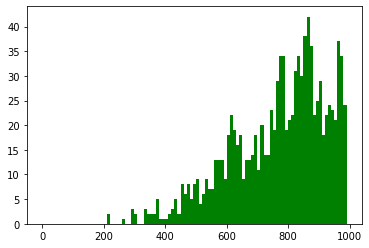

In [13]:
bins = range(0,1000,10)
plt.hist(frec_distance, bins, color="g", histtype="bar")
plt.show()

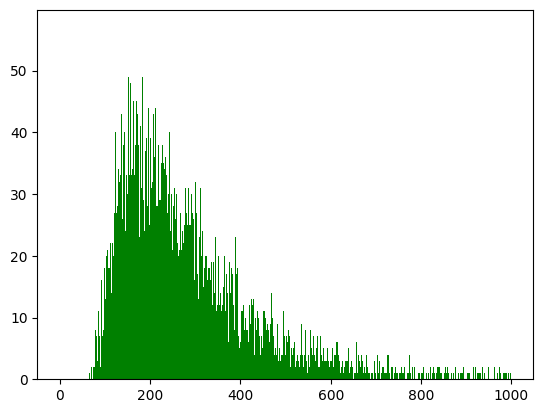

In [117]:
bins = range(0,1000,1)
plt.hist(f_se, bins, color="g", histtype="bar")
plt.show()

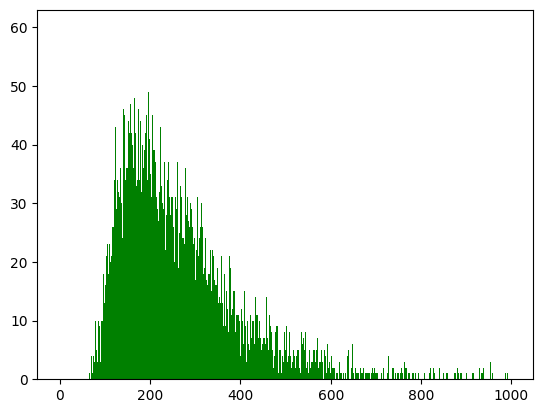

In [118]:
bins = range(0,1000,1)
plt.hist(f_d, bins, color="g", histtype="bar")
plt.show()

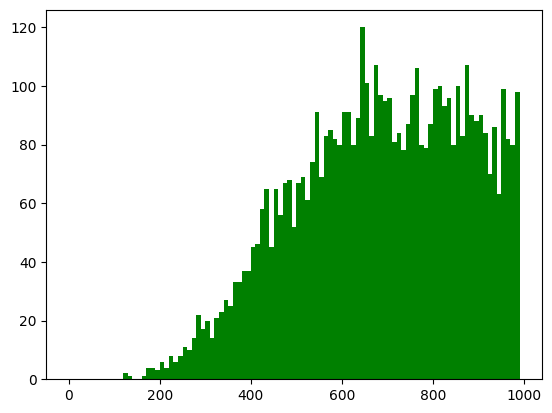

In [119]:
bins = range(0,1000,10)
plt.hist(haud_distance, bins, color="g", histtype="bar")
plt.show()

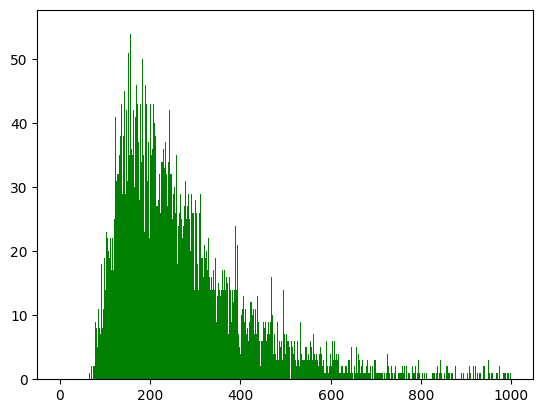

In [120]:
bins = range(0,1000,1)
plt.hist(h_se, bins, color="g", histtype="bar")
plt.show()

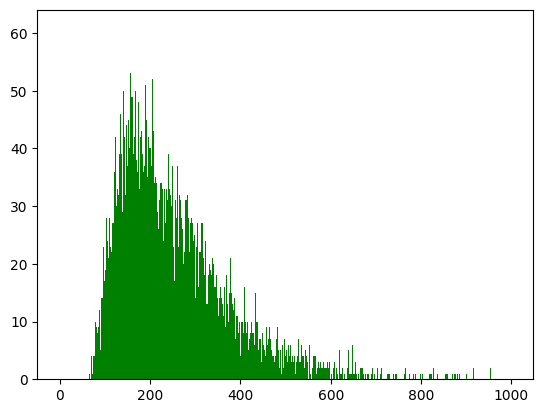

In [121]:
bins = range(0,1000,1)
plt.hist(h_d, bins, color="g", histtype="bar")
plt.show()